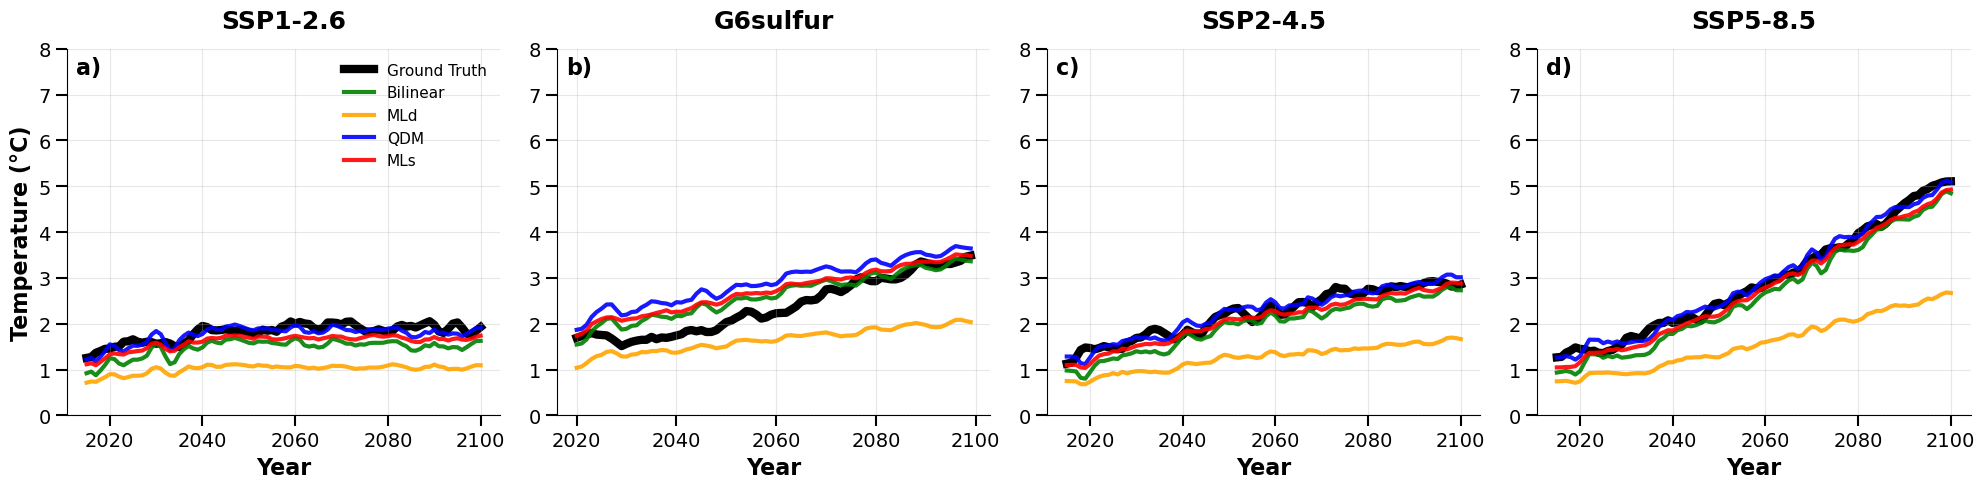

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Load original datasets for baseline calculation
data_dir = Path("../data")
ds_hist_orig = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")

# Scenarios (add g6sulfur after ssp126)
scenarios = ['ssp126', 'g6sulfur', 'ssp245', 'ssp585']
scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'g6sulfur': 'G6sulfur',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Variable
var = 'tas'
var_label = 'Temperature (°C)'

# Model names and colors
models = ['groundtruth', 'bilinear', 'qdm', 'mld', 'mls']
model_labels = {
    'groundtruth': 'Ground Truth',
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

model_colors = {
    'groundtruth': 'black',
    'bilinear': 'green',
    'qdm': 'blue',
    'mld': 'orange',
    'mls': 'red'
}

# Y-axis configuration
ylim = (0, 8)
ytick = 1

def calc_baseline(ds, var, start_year=1850, end_year=1900):
    """Calculate baseline mean for reference period"""
    var_hr = f"{var}_hr"
    data = ds[var_hr]
    years = ds.time.dt.year
    mask = (years >= start_year) & (years <= end_year)
    baseline_data = data.isel(time=mask)
    baseline = baseline_data.mean(dim=['time', 'lat', 'lon'])
    return float(baseline.values)

def calc_global_mean(data):
    """Calculate simple global mean"""
    return np.mean(data, axis=(1, 2))

def to_annual_mean(data, time_coords):
    """Convert to annual averages"""
    years = time_coords.dt.year.values
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean to annual data"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Calculate baseline
baseline_mean = calc_baseline(ds_hist_orig, var, 1850, 1900)

# Create 1x4 figure
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Panel labels
panel_labels = ['a)', 'b)', 'c)', 'd)']

for col, scenario in enumerate(scenarios):
    ax = axes[col]
    
    # Determine time slice based on scenario
    if scenario == 'g6sulfur':
        time_slice = slice('2020', '2099')
    else:
        time_slice = slice('2015', '2100')
    
    # Load main results (for groundtruth, bilinear, MLd)
    main_file = results_dir / f"{var}_evaluation_{scenario}.nc"
    
    if main_file.exists():
        ds_main = xr.open_dataset(main_file)
        gt_data = ds_main['groundtruth'].sel(time=time_slice).values
        time_coords = ds_main['groundtruth'].sel(time=time_slice).time
        
        # Calculate ground truth statistics
        gt_mean = calc_global_mean(gt_data) - baseline_mean
        years_gt, gt_mean_annual = to_annual_mean(gt_mean, time_coords)
        gt_mean_smooth = smooth_data(gt_mean_annual)
        
        # 1. Plot ground truth (bottom layer) - thick solid line
        ax.plot(years_gt, gt_mean_smooth, 
               color=model_colors['groundtruth'],
               linestyle='-',
               linewidth=6,
               label=model_labels['groundtruth'], zorder=1)
        
        # 2. Plot bilinear (input)
        if 'input' in ds_main:
            input_data = ds_main['input'].sel(time=time_slice).values
            input_mean = calc_global_mean(input_data) - baseline_mean
            years_input, input_mean_annual = to_annual_mean(input_mean, time_coords)
            input_mean_smooth = smooth_data(input_mean_annual)
            
            ax.plot(years_input, input_mean_smooth, 
                   color=model_colors['bilinear'],
                   linestyle='-',
                   linewidth=3,
                   label=model_labels['bilinear'], alpha=0.9, zorder=2)
        
        # 3. Plot MLd (zscore_pixel)
        if 'pred_zscore_pixel' in ds_main:
            pred_data = ds_main['pred_zscore_pixel'].sel(time=time_slice).values
            pred_mean = calc_global_mean(pred_data) - baseline_mean
            years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
            pred_mean_smooth = smooth_data(pred_mean_annual)
            
            ax.plot(years_pred, pred_mean_smooth, 
                   color=model_colors['mld'],
                   linestyle='-',
                   linewidth=3,
                   label=model_labels['mld'], alpha=0.9, zorder=3)
    
    # Load QDM results
    qdm_file = results_dir / f"{var}_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        
        if 'pred_qdm' in ds_qdm:
            pred_data = ds_qdm['pred_qdm'].sel(time=time_slice).values
            pred_mean = calc_global_mean(pred_data) - baseline_mean
            years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
            pred_mean_smooth = smooth_data(pred_mean_annual)
            
            ax.plot(years_pred, pred_mean_smooth, 
                   color=model_colors['qdm'],
                   linestyle='-',
                   linewidth=3,
                   label=model_labels['qdm'], alpha=0.9, zorder=4)
    
    # Load residual results (for MLs)
    residual_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        
        if 'pred_grid' in ds_residual:
            pred_data = ds_residual['pred_grid'].sel(time=time_slice).values
            pred_mean = calc_global_mean(pred_data) - baseline_mean
            years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
            pred_mean_smooth = smooth_data(pred_mean_annual)
            
            ax.plot(years_pred, pred_mean_smooth, 
                   color=model_colors['mls'],
                   linestyle='-',
                   linewidth=3,
                   label=model_labels['mls'], alpha=0.9, zorder=5)
    
    # Format axes
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Set y-axis
    ax.set_ylim(ylim)
    ax.set_yticks(np.arange(ylim[0], ylim[1] + ytick/2, ytick))
    
    # Add panel label
    ax.text(0.02, 0.98, panel_labels[col],
           transform=ax.transAxes,
           fontsize=16, fontweight='bold',
           va='top', ha='left')
    
    # Labels
    ax.set_title(scenario_labels[scenario], fontsize=18, fontweight='bold', pad=15)
    
    if col == 0:
        ax.set_ylabel(var_label, fontsize=16, fontweight='bold')
    
    ax.set_xlabel('Year', fontsize=16, fontweight='bold')
    
    # Legend (only on first panel)
    if col == 0:
        ax.legend(loc='best', fontsize=11, frameon=False)
    
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Increase tick parameters
    ax.tick_params(labelsize=14, length=8, width=1.5)

plt.tight_layout()

output_file = figures_dir / "fig3.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

plt.show()